# How to Build a Video Segment Copy Detection System

In the previous example we have demonstrated how to use milvus and towhee to build a simple video deduplication system at video level. In this tutorial, we will demonstrate video duplication detection down to segment level. 

**What's the differents between video-level deduplication and segment-level deduplication?**


- Video-level deduplication is a method for situations with high repetition. It finds duplicate videos by comparing the similarity between the embeddings of the whole video. Since only one embedding is extracted from a video, this method works faster. But the limitation of this method is also obvious: it is not good for detecting similar videos of different lengths. For example, the first quarter of video A and video B are exactly the same, but their embeddings may not be similar. In this case, it is obviously impossible to detect infringing content.
 
- Segment-level deduplication detects the specific start and end times of repeated segments, which can handle complex clipping and insertion of video segments as well as situations where the video lengths are not equal. It does so by comparing the similarity between video frames. Obviously, we need to use this method in the actual task of mass video duplication checking. Of course, the speed of this method will be slower than the one of video level.

**What are Milvus & Towhee?**

- [Milvus](https://milvus.io/) is the most advanced open-source vector database built for AI applications and supports nearest neighbor embedding search across tens of millions of entries.
- [Towhee](https://towhee.io/) is a framework that provides ETL for unstructured data using SoTA machine learning models.

In this tutorial, we will demonstrate video duplication detection at segment level using Towhee and Milvus. Moreover, we managed to make the core functionality as simple as few lines of code, with which you can start hacking your own video deduplication engine.


## Preparation

### Install packages

Make sure you have installed required python packages:

| package |
| -- |
| pymilvus |
| towhee |
| pillow |
| ipython |
| numpy |
| plyvel |

In [1]:
! python -m pip install -q pymilvus towhee pillow ipython numpy plyvel

### Prepare the data

First, we need to prepare the dataset and Milvus environment.   

The VCDB core dataset is almost all full video length repetition, which is not suitable for the evaluation of segment repetition detection technology. In this tutorial, we use [VCSL dataset](https://arxiv.org/abs/2203.02654). 

VCSL is a large-scale real dataset for video duplication detection from Youtube and Bilibili. Unlike VCDB, its cheating changes to video frames are more complex, including crop, filter, text overlay, background, cam-cording, picture in picture, even recent deepfake, etc. there are a wide range of content transformations among over 280k segment copies in VCSL, and these realistic skillful transformations bring great challenges to segment-level copy detection. 

In this tutorial, we use only a mini set of VCSL. It contains 5 events with three videos in each event, which are copies of each other. There is also a broken video in folder `crashed_video` for robustness testing.

In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/VCSL-demo.zip -O
! unzip -q -o VCSL-demo.zip

The directory structure of this demo dataset is like this:
```
./VCSL-demo/
├── baisuishan
│   ├── 03584e404c0847fcbe5f9c486e8f8fc7-【宇哥】原来百岁山的广告是这个意思！-1UE411V74D.flv
│   ├── 217a12c936414660a53b55b22e2aea59-20200607百岁山-1kf4y127GB.flv
│   └── 41c4eaced0d24ebba50d180026531025-廣東有線翡翠台「瞬間看地球」+插播「百歲山」廣告（錄影時間：2019年12月23日 上午8時55分）-1UJ411s7we.flv
├── crashed_video
│   └── Clip46_KingKong_MP4_Sorenson_750K_720x404_30fps_16x9_MPAA.mp4
├── donghua
│   ├── 043bee7a71f347f18e8576bb1a01c86b-Langrisser M 'Dream Simulation' OPレオンが戻ってきた-y3qAPvWnL18.mkv
│   ├── 1134884a6c544a00b3bce99457a2a98d-LANGRISSER Mobile OP-EA4PmSWGr8o.mp4
│   └── 1b4e048011714eab928650f64e6370a6-123-JqSBkvPsYBw.mkv
├── huangpi
│   ├── 01414786cbe74d2d95e2b71df26f39a3-【外星金轮】金轮....已经无所谓了  (反正马老师看不到)-1sh411B7g1.flv
│   ├── 0fba4debd48245699971c4c18608cde3-黄皮外星人 低成本大制作-1vP4y1s79h.flv
│   └── 9ec6f467472a428e91fd45bb688e3be1-酒醉的广场黄皮外星人-1uU4y1E7n6.flv
├── liulangdiqiu
│   ├── d62ce5becff14a0c9c7dab5eea6647dc-《流浪地球》吴京成青少年偶像，新闻联播盛赞：中国人的浪漫科幻-1qf4y1G7gM.flv
│   ├── e5dc80abd7a24b47accde190c9fdbcdc-【新闻联播】流浪地球上央视一套7点档啦-1db411m7f8.flv
│   └── ef65e0f662e646a88a13b6eddb640e48-《流浪地球》上《新闻联播》排面鸭！CCTV央视给力！-1xb411U7uE.flv
└── madongmei
    ├── 0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv
    ├── 8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv
    └── ad244c924f31461a9d809c77ae251ac1-夏洛特烦恼沈腾和大爷的经典对话，马什么梅，马冬什么，什么冬梅-1y7411n7y1.flv
```

Define some helper function to convert video to gif so that we can have a look at these videos.   

In [3]:
from IPython import display
from pathlib import Path
import towhee
from PIL import Image as PILImage
import os

def display_gif(video_path_list, text_list):
    html = ''
    for video_path, text in zip(video_path_list, text_list):
        html_line = '<img src="{}"> {} <br/><br/>'.format(video_path, text)
        html += html_line
    return display.HTML(html)

    
def convert_video2gif(video_path, output_gif_path, start_time=0.0, end_time=1000.0, num_samples=16):
    frames = (
        towhee.glob(video_path)
              .video_decode.ffmpeg(start_time=start_time, end_time=end_time, sample_type='time_step_sample', args={'time_step': 3})
              .to_list()[0]
    )
    imgs = [PILImage.fromarray(frame) for frame in frames]
    imgs = [img.resize((int(img.width/6), int(img.height/6)), PILImage.NEAREST) for img in imgs]
    imgs[0].save(fp=output_gif_path, format='GIF', append_images=imgs[1:], save_all=True, loop=0)


def display_gifs_from_video(video_path_list, text_list, start_time_list = None, end_time_list = None, tmpdirname = './tmp_gifs'):
    Path(tmpdirname).mkdir(exist_ok=True)
    gif_path_list = []
    for i, video_path in enumerate(video_path_list):
        video_name = str(Path(video_path).name).split('.')[0]
        gif_path = Path(tmpdirname) / (video_name + '.gif')
        if start_time_list is not None:
            convert_video2gif(video_path, gif_path, start_time=start_time_list[i], end_time=end_time_list[i])
        else:
            convert_video2gif(video_path, gif_path)
        gif_path_list.append(gif_path)
    return display_gif(gif_path_list, text_list)

In [4]:
import random
random.seed(9)
vcsl_demo_root = './VCSL-demo/'

event_list = os.listdir(vcsl_demo_root)
if 'crashed_video' in event_list:
    event_list.remove('crashed_video')

random_event = random.choice(event_list)
random_event_folder = os.path.join(vcsl_demo_root, random_event)
random_event_videos = [os.path.join(random_event_folder, video_file) for video_file in os.listdir(random_event_folder)]
tmpdirname = './tmp_gifs'
display_gifs_from_video(random_event_videos, random_event_videos, tmpdirname=tmpdirname)

In [5]:
import towhee
import numpy as np
from towhee.types import Image


os.environ["CUDA_VISIBLE_DEVICES"] = '1'


@towhee.register
def get_image(x):
	for i in x:
		yield Image(i.__array__(), 'RGB')

@towhee.register
def merge_ndarray(x):
	return np.concatenate(x).reshape(-1, x[0].shape[0])

@towhee.register
def split_res(x):
	return [i.path for i in x], [i.score for i in x]

### Create a Milvus Collection

Before getting started, please make sure you have [installed milvus](https://milvus.io/docs/v2.1.x/install_standalone-docker.md). Let's first create a `video_deduplication` collection that uses the [L2 distance metric](https://milvus.io/docs/v2.1.x/metric.md#Euclidean-distance-L2) and an [IVF_FLAT index](https://milvus.io/docs/v2.1.x/index.md#IVF_FLAT).

In [6]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

connections.connect(host='127.0.0.1', port='19530')

def create_milvus_collection(collection_name, dim):
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
        FieldSchema(name='id', dtype=DataType.INT64, descrition='id of the embedding', is_primary=True, auto_id=True),
        FieldSchema(name='path', dtype=DataType.VARCHAR,  descrition='path of the embedding',max_length=500),
        FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='video embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='video dedup')
    collection = Collection(name=collection_name, schema=schema)

    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":1}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

collection = create_milvus_collection('video_deduplication', 256)


## Video Copy Detection

In this section, we'll show how to build our Video Copy Detection engine using Milvus. The basic idea behind Video Copy Detection is the extract embeddings from videos using Deep Neural Network and store them in Milvus, then get query videos embeddings and compare with those stored in Milvus.

We use [Towhee](https://towhee.io/), a machine learning framework that allows for creating data processing pipelines. [Towhee](https://towhee.io/) also provides predefined operators which implement insert and query operation in Milvus.


### Load Video Embeddings into Milvus

For every video, we decode it to image frames, and then using neural network to extract their embeddings. We insert them to Milvus and levelDB for storage.
![](video_decopy_insert.png)


In [7]:
%%time

all_file_pattern = os.path.join(vcsl_demo_root, '*', '*.*')

dc = (
	towhee.glob['video_url'](all_file_pattern).stream()
		.video_decode.ffmpeg['video_url', 'frames'](sample_type='time_step_sample', args={'time_step': 1})
		.get_image['frames', 'images']()
		.flatten('images')
		.drop_empty()
		.image_embedding.isc['images', 'embeddings']()
		.select['video_url', 'embeddings']()
		.ann_insert.milvus[('video_url', 'embeddings'), 'insert_result'](uri='tcp://localhost:19530/video_deduplication')
		.group_by('video_url')
		.merge_ndarray['embeddings', 'video_embedding']()
		.insert_leveldb[('video_url', 'video_embedding'), ]('url_vec.db')
		.select['video_url', 'video_embedding']()
		.show(limit=20)
)

2022-09-28 19:35:52,189 - 139924476200768 - video_decoder.py-video_decoder:120 - ERROR: header damaged


video_url,video_embedding
./VCSL-demo/huangpi/0fba4debd48245699971c4c18608cde3-黄皮外星人 低成本大制作-1vP4y1s79h.flv,"[-0.020633303, -0.056049056, -0.021473853, ...] shape=(118, 256)"
./VCSL-demo/huangpi/01414786cbe74d2d95e2b71df26f39a3-【外星金轮】金轮....已经无所谓了 (反正马老师看不到)-1sh411B7g1.flv,"[-0.03947173, -0.010356861, -0.08993856, ...] shape=(90, 256)"
./VCSL-demo/huangpi/9ec6f467472a428e91fd45bb688e3be1-酒醉的广场黄皮外星人-1uU4y1E7n6.flv,"[0.009808735, -0.016826384, 0.06355846, ...] shape=(59, 256)"
./VCSL-demo/baisuishan/41c4eaced0d24ebba50d180026531025-廣東有線翡翠台「瞬間看地球」+插播「百歲山」廣告（錄影時間：2019年12月23日 上午8時55分）-1UJ411s7we.flv,"[-0.020499738, -0.105837084, 0.07808163, ...] shape=(281, 256)"
./VCSL-demo/baisuishan/217a12c936414660a53b55b22e2aea59-20200607百岁山-1kf4y127GB.flv,"[0.02334698, -0.022769544, 0.03606544, ...] shape=(61, 256)"
./VCSL-demo/baisuishan/03584e404c0847fcbe5f9c486e8f8fc7-【宇哥】原来百岁山的广告是这个意思！-1UE411V74D.flv,"[-0.02180116, -0.04651391, 0.031187996, ...] shape=(227, 256)"
./VCSL-demo/liulangdiqiu/d62ce5becff14a0c9c7dab5eea6647dc-《流浪地球》吴京成青少年偶像，新闻联播盛赞：中国人的浪漫科幻-1qf4y1G7gM.flv,"[-0.048483953, -0.08141277, 0.117679514, ...] shape=(103, 256)"
./VCSL-demo/liulangdiqiu/ef65e0f662e646a88a13b6eddb640e48-《流浪地球》上《新闻联播》排面鸭！CCTV央视给力！-1xb411U7uE.flv,"[0.07897866, 0.09988424, 0.077609695, ...] shape=(198, 256)"
./VCSL-demo/liulangdiqiu/e5dc80abd7a24b47accde190c9fdbcdc-【新闻联播】流浪地球上央视一套7点档啦-1db411m7f8.flv,"[-0.0009121081, 0.0041335938, -0.011865338, ...] shape=(33, 256)"
./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,"[-0.058290888, -0.082258746, -0.015635852, ...] shape=(84, 256)"


CPU times: user 4h 19min 49s, sys: 6min 7s, total: 4h 25min 57s
Wall time: 4min 31s


If you see "ERROR: header damaged", it's because the sample dataset already has a corrupt video and we skip it. This is to simulate that in practice, where there may be a small amount of corrupted video in the huge video data, but they should not affect the execution of other normal video.

### Query videos

In theory, for each query video, it is necessary to match and retrieve all the videos in the database, which will cause huge overhead. In this tutorial, we perform a rough video selection which filter the videos with low similarity to solve this problem. 
 
First, for every query frame, we retrieve a certain number of similar frames through Milvus, which match for a specified video. The videos of these frames are then aggregated, sorted, and filtered. Then, the video embeddings of remaining videos and embedding of the query video are processed for localizing copyed segments. In this way, we can filter out videos with low similarity, saving a lot of computation for the whole pipeline.
![](video_decopy_query.png)

In [8]:
%%time
collection.load()

query_file_pattern = os.path.join(vcsl_demo_root, 'madongmei', '*.*')

dc = (
	towhee.glob['query_url'](query_file_pattern).stream()
		.video_decode.ffmpeg['query_url', 'frames'](sample_type='time_step_sample', args={'time_step': 1})
		.get_image['frames', 'images']()
		.flatten('images')
		.drop_empty()
		.image_embedding.isc['images', 'embeddings']()
		.select['query_url', 'embeddings']()
		.ann_search.milvus['embeddings', 'results'](collection=collection, limit=64, output_fields=['path'], metric_type='IP')
		.split_res['results', ('retrieved_urls','scores')]()
		.group_by('query_url')
		.video_copy_detection.select_video[('retrieved_urls','scores'), 'ref_url'](top_k=5, reduce_function='sum', reverse=True)
		.from_leveldb['ref_url', 'retrieved_embedding']('url_vec.db', True)
		.merge_ndarray['embeddings', 'video_embedding']()
		.flatten('retrieved_embedding', 'ref_url')
		.video_copy_detection.temporal_network[('video_embedding', 'retrieved_embedding'), ('predict_segments', 'segment_scores')]()
		.select['query_url',  'ref_url', 'predict_segments', 'segment_scores']()
		.show(limit=50)
)

query_url,ref_url,predict_segments,segment_scores
./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,"[[0, 0, 83, 83]] len=1",[1.0120481697909802] len=1
./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv,"[[1, 142, 25, 164],[33, 147, 83, 167]] len=2","[0.5936586727266726,0.30687750790800367] len=2"
./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,./VCSL-demo/madongmei/ad244c924f31461a9d809c77ae251ac1-夏洛特烦恼沈腾和大爷的经典对话，马什么梅，马冬什么，什么冬梅-1y7411n7y1.flv,"[[1, 0, 25, 19],[30, 3, 76, 23]] len=2","[0.6433955236922863,0.3173292292789979] len=2"
./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,./VCSL-demo/donghua/043bee7a71f347f18e8576bb1a01c86b-Langrisser M 'Dream Simulation' OPレオンが戻ってきた-y3qAPvWnL18.mkv,,
./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,./VCSL-demo/liulangdiqiu/ef65e0f662e646a88a13b6eddb640e48-《流浪地球》上《新闻联播》排面鸭！CCTV央视给力！-1xb411U7uE.flv,,
./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv,./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv,"[[0, 0, 167, 167]] len=1",[1.0059880264504941] len=1
./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv,./VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv,"[[141, 1, 164, 25]] len=1",[0.5107154262826797] len=1
./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv,./VCSL-demo/liulangdiqiu/ef65e0f662e646a88a13b6eddb640e48-《流浪地球》上《新闻联播》排面鸭！CCTV央视给力！-1xb411U7uE.flv,,
./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv,./VCSL-demo/baisuishan/41c4eaced0d24ebba50d180026531025-廣東有線翡翠台「瞬間看地球」+插播「百歲山」廣告（錄影時間：2019年12月23日 上午8時55分）-1UJ411s7we.flv,,
./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv,./VCSL-demo/madongmei/ad244c924f31461a9d809c77ae251ac1-夏洛特烦恼沈腾和大爷的经典对话，马什么梅，马冬什么，什么冬梅-1y7411n7y1.flv,"[[141, 0, 164, 22]] len=1",[0.7525816652509901] len=1


CPU times: user 1h 2min 32s, sys: 1min 29s, total: 1h 4min 2s
Wall time: 1min 17s


For each frame of each query video, we query the most similar frame information of 64 frames from Milvus. We aggregate and sort this information, and select candidate videos with topk=5. For this query video and the corresponding 5 candidate videos, `temporal_network` calculation is performed, and finally the detected duplicate segments are obtained. 

Note that our query uses the same dataset, in which there are 5 events, and each event has 3 videos, which are copies of each other. Using this dataset to query itself means that for each video, the correct query result should be the three videos under its own event. 

The output `range` column is detected segments list, which format is list of `[query_start_second, ref_start_second, query_end_second, ref_end_second]`. We can observe that each query video does detect only 3 results of its own event, which is consistent with ground truth.
 
Let's take the result of the 7th line as an example, with `predict_segments` = [141, 1, 164, 25], indicating that in the query video, from 141 to 164 seconds, and the ref video from 1 to 25 seconds are repeated. We can display these clips.
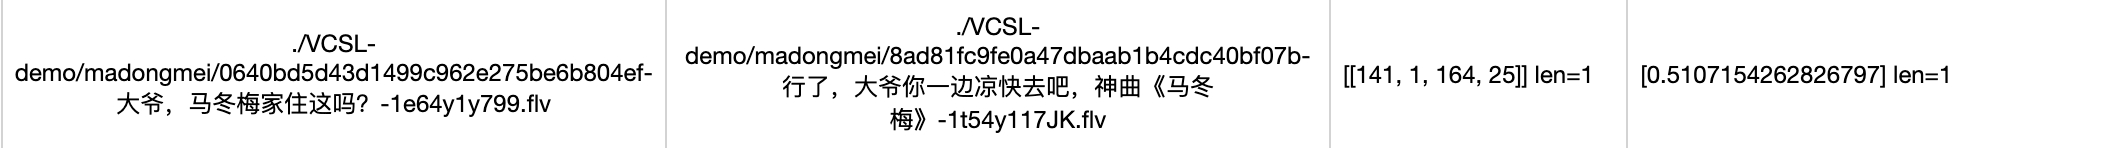

In [9]:
event_videos = ['./VCSL-demo/madongmei/0640bd5d43d1499c962e275be6b804ef-大爷，马冬梅家住这吗？-1e64y1y799.flv',
               './VCSL-demo/madongmei/8ad81fc9fe0a47dbaab1b4cdc40bf07b-行了，大爷你一边凉快去吧，神曲《马冬梅》-1t54y117JK.flv']
tmpdirname2 = './tmp_gifs2'

display_gifs_from_video(event_videos, event_videos, start_time_list=[141, 1], end_time_list=[164, 25], tmpdirname=tmpdirname2)

In [10]:
# import shutil
# shutil.rmtree(tmpdirname)
# shutil.rmtree(tmpdirname2)